## Data Discovery

Data discovery of the energy forecast.

In [1]:
from google.datalab import bigquery as bq
import pandas as pd

In [ ]:
datetime.

In [3]:
from datetime import datetime, timedelta
def get_daily_data(start_timestamp, end_date=None, delta=22):
  date_format = '%Y-%m-%d %H:%M:%S'
  start_date = datetime.strptime(start_timestamp, date_format)
  if end_date is not None:
    end_date = datetime.strptime(end_date, date_format)
  else:
    end_date = start_date + timedelta(hours=delta)
  query_day = """
  SELECT 
    *
  FROM (
  SELECT 
    f.prediction_date,
    AVG(f.wind_speed_100m) as avg_wind_speed_100m,
    AVG(f.wind_direction_100m) as avg_wind_direction_100m,
    AVG(f.temperature) as avg_temperature,
    AVG(f.air_density) as avg_air_density,
    AVG(f.pressure) as avg_pressure,
    AVG(f.precipitation) as avg_precipitation,
    AVG(f.wind_gust) as avg_wind_gust,
    AVG(f.radiation) as avg_radiation,
    AVG(f.wind_speed) as avg_wind_speed,
    AVG(f.wind_direction) as avg_wind_direction,
    AVG(p.price) as price,
    ABS(FARM_FINGERPRINT(CAST(AVG(f.wind_direction) as STRING))) as key
  FROM
     `energy.historical_forecasting` as f
  JOIN
     `energy.market_price` as p
  ON
     p.date = f.prediction_date
  GROUP BY
    f.prediction_date
  ) as h
  WHERE
    h.prediction_date >= TIMESTAMP('{}')
  AND
    h.prediction_date <= TIMESTAMP('{}')
  ORDER BY
    h.prediction_date
  """.format(datetime.strftime(start_date, date_format), datetime.strftime(end_date, date_format))
  return bq.Query(query_day).execute().result().to_dataframe()

In [4]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
from random import randrange

#from google.appengine.api import app_identity

PRICE_AVG = 50.137042042
PRICE_STD = 12.4445612361
PRICE_MIN = 30.0
PRICE_MAX = 40.0

def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    service = discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

def get_standard(value):
    return((value - PRICE_AVG) / PRICE_STD)

def get_value(standard):
    return((standard * PRICE_STD) + PRICE_AVG)

def window_prediction(prices, number_of_pred, version):
    results = []
    prices_std = [get_standard(p) for p in prices]
    for h in range(number_of_pred):
        result = predict_json('qwiklabs-gcp-aebfb78fe0f1b1d1', 
                              'energy_price_forecast',
                              {"price": prices_std}, 
                              version=version
                             )
        if isinstance(result[0]['predicted'], list):
            standard_price = result[0]['predicted'][0]
        else:
            standard_price = result[0]['predicted']

        prices_std.pop(0)
        prices_std.append(standard_price)
        results.append(get_value(standard_price))

    return results



In [8]:
df = get_daily_data('2015-09-01 00:00:00', end_date='2015-10-19 11:00:00', delta=None)
result = pd.DataFrame()
result['date'] = df['prediction_date']
result['price'] = df['price']
result['predicted_price'] = 0.0
for idx,price in enumerate(df['price']):
  if idx < 23:
    result.iloc[idx, 2] = 0.0
  else:
    price_window = df['price'].iloc[(idx - 23):idx].values.tolist()
    result.iloc[idx, 2] = window_prediction(price_window, 1, 'RNN')[0]    
    
#results = window_prediction(a, 1, 'RNN')
result.head(50)

,date,price,predicted_price
0,2015-09-01 00:00:00,48.62,0.000000
1,2015-09-01 01:00:00,47.69,0.000000
2,2015-09-01 02:00:00,45.85,0.000000
3,2015-09-01 03:00:00,45.78,0.000000
4,2015-09-01 04:00:00,49.30,0.000000
5,2015-09-01 05:00:00,55.93,0.000000
6,2015-09-01 06:00:00,60.47,0.000000
7,2015-09-01 07:00:00,57.50,0.000000
8,2015-09-01 08:00:00,59.57,0.000000
9,2015-09-01 09:00:00,60.47,0.000000


In [12]:
result.to_csv(path_or_buf='rnn.csv',header=False,index=False, float_format='%.2f')

In [16]:
!ls ../

discovery  hello.ipynb	models	README.md  Test.ipynb


In [24]:
query_all = """
SELECT 
  *
FROM (
SELECT 
  f.prediction_date,
  AVG(f.wind_speed_100m) as avg_wind_speed_100m,
  AVG(f.wind_direction_100m) as avg_wind_direction_100m,
  AVG(f.temperature) as avg_temperature,
  AVG(f.air_density) as avg_air_density,
  AVG(f.pressure) as avg_pressure,
  AVG(f.precipitation) as avg_precipitation,
  AVG(f.wind_gust) as avg_wind_gust,
  AVG(f.radiation) as avg_radiation,
  AVG(f.wind_speed) as avg_wind_speed,
  AVG(f.wind_direction) as avg_wind_direction,
  AVG(p.price) as price,
  ABS(FARM_FINGERPRINT(CAST(AVG(f.wind_direction) as STRING))) as key
FROM
   `energy.historical_forecasting` as f
JOIN
   `energy.market_price` as p
ON
   p.date = f.prediction_date
GROUP BY
  f.prediction_date
) as h
ORDER BY
  h.prediction_date
"""

df = bq.Query(query_all).execute().result().to_dataframe()
price_std = df['price'].std()
price_avg = df['price'].mean()
price_max = df['price']

In [25]:
print('avg: {}, std: {}, min: {}, max: {}'.format(price_avg, price_std, price_min, price_max))

avg: 50.137042042, std: 12.4445612361, min: 4.0, max: 85.05


In [16]:
query_1 = """
SELECT 
  sl.point,
  sl.lat,
  sl.long,
  f.prediction_date,
  f.wind_speed_100m,
  f.wind_direction_100m,
  f.temperature,
  f.air_density,
  f.pressure,
  f.precipitation,
  f.wind_gust,
  f.radiation,
  f.wind_speed,
  f.wind_direction,
  f.price
FROM
  (SELECT 
      h.prediction_date,
      p.price,
      h.wind_speed_100m,
      h.wind_direction_100m,
      h.temperature,
      h.air_density,
      h.pressure,
      h.precipitation,
      h.wind_gust,
      h.radiation,
      h.wind_speed,
      h.wind_direction,
      h.point
   FROM
      `energy.historical_forecasting` as h
   JOIN
      `energy.market_price` as p
   ON
      p.date = h.prediction_date
  ) as f
JOIN
  `energy.station_location` as sl
ON
  f.point = sl.point
ORDER BY
  f.prediction_date
"""

query_train = """
SELECT 
  *
FROM (
SELECT 
  f.prediction_date,
  AVG(f.wind_speed_100m) as avg_wind_speed_100m,
  AVG(f.wind_direction_100m) as avg_wind_direction_100m,
  AVG(f.temperature) as avg_temperature,
  AVG(f.air_density) as avg_air_density,
  AVG(f.pressure) as avg_pressure,
  AVG(f.precipitation) as avg_precipitation,
  AVG(f.wind_gust) as avg_wind_gust,
  AVG(f.radiation) as avg_radiation,
  AVG(f.wind_speed) as avg_wind_speed,
  AVG(f.wind_direction) as avg_wind_direction,
  AVG(p.price) as price,
  ABS(FARM_FINGERPRINT(CAST(AVG(f.wind_direction) as STRING))) as key
FROM
   `energy.historical_forecasting` as f
JOIN
   `energy.market_price` as p
ON
   p.date = f.prediction_date
GROUP BY
  f.prediction_date
) as h
WHERE
  h.prediction_date <= TIMESTAMP('2015-08-31 23:59:59')
ORDER BY
  h.prediction_date
"""

train_set = bq.Query(query_train).execute().result().to_dataframe()
train_set.describe()

,avg_wind_speed_100m,avg_wind_direction_100m,avg_temperature,avg_air_density,avg_pressure,avg_precipitation,avg_wind_gust,avg_radiation,avg_wind_speed,avg_wind_direction,price,key
count,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5.568000e+03
mean,4.840121,190.330583,14.512328,1.134799,935.860184,0.097845,4.913907,231.563338,3.250229,189.997153,49.925562,4.584549e+18
std,1.888755,59.411332,10.172903,0.041616,6.404097,0.200544,2.331450,273.987265,1.270344,57.915837,13.010238,2.651209e+18
min,1.372222,47.883333,-6.044444,1.036111,913.800000,0.000000,1.194444,0.000000,0.855556,50.538889,4.000000,1.976202e+15
25%,3.626389,143.000000,6.248611,1.107778,932.366667,0.000000,3.372222,0.000000,2.333333,143.933333,42.240000,2.292846e+18
50%,4.572222,193.055556,13.836111,1.134444,935.200000,0.000000,4.436111,93.477778,3.027778,192.661111,50.480000,4.622282e+18
75%,5.605556,233.756944,21.045833,1.166111,938.527778,0.100000,5.716667,425.841667,3.923611,232.508333,60.195000,6.865685e+18
max,15.044444,329.544444,41.044444,1.229444,961.238889,1.100000,16.705556,954.288889,9.638889,327.711111,85.050000,9.220779e+18


In [17]:
query_valid = """
SELECT 
  *
FROM (
SELECT 
  f.prediction_date,
  AVG(f.wind_speed_100m) as avg_wind_speed_100m,
  AVG(f.wind_direction_100m) as avg_wind_direction_100m,
  AVG(f.temperature) as avg_temperature,
  AVG(f.air_density) as avg_air_density,
  AVG(f.pressure) as avg_pressure,
  AVG(f.precipitation) as avg_precipitation,
  AVG(f.wind_gust) as avg_wind_gust,
  AVG(f.radiation) as avg_radiation,
  AVG(f.wind_speed) as avg_wind_speed,
  AVG(f.wind_direction) as avg_wind_direction,
  AVG(p.price) as price,
  ABS(FARM_FINGERPRINT(CAST(AVG(f.wind_direction) as STRING))) as key
FROM
   `energy.historical_forecasting` as f
JOIN
   `energy.market_price` as p
ON
   p.date = f.prediction_date
GROUP BY
  f.prediction_date
) as h
WHERE
  h.prediction_date > TIMESTAMP('2015-08-31 23:59:59')
ORDER BY
  h.prediction_date
"""

eval_set = bq.Query(query_valid).execute().result().to_dataframe()
eval_set.describe()

,avg_wind_speed_100m,avg_wind_direction_100m,avg_temperature,avg_air_density,avg_pressure,avg_precipitation,avg_wind_gust,avg_radiation,avg_wind_speed,avg_wind_direction,price,key
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1.092000e+03
mean,4.574888,184.800041,16.836533,1.120717,932.568320,0.215385,4.637576,190.650443,3.058878,183.619531,51.215357,4.620817e+18
std,2.295459,51.204956,5.870233,0.022343,3.535393,0.388163,2.858560,219.027697,1.535335,49.975367,8.952255,2.645148e+18
min,1.488889,67.072222,5.105556,1.062222,920.494444,0.000000,1.411111,0.000000,0.972222,65.366667,12.000000,1.473987e+16
25%,3.216667,140.759722,12.322222,1.103333,930.825000,0.000000,2.909722,0.000000,2.100000,142.141667,45.770000,2.311265e+18
50%,4.027778,185.958333,15.391667,1.123889,933.116667,0.100000,3.788889,99.155556,2.680556,183.727778,52.290000,4.705971e+18
75%,5.030556,224.458333,21.019444,1.138333,934.972222,0.200000,5.084722,358.444444,3.405556,222.698611,58.210000,6.888004e+18
max,14.150000,305.983333,33.455556,1.164444,939.416667,1.700000,16.522222,771.666667,9.738889,297.372222,68.480000,9.195093e+18


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


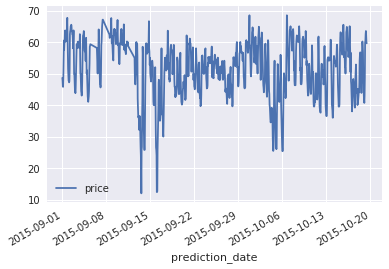

In [6]:
eval_set.plot(x='prediction_date', y='price')

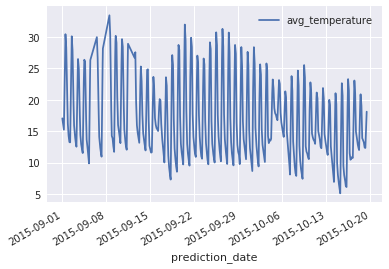

In [7]:
eval_set.plot(x='prediction_date', y='avg_temperature')

In [14]:
def write_df_to_file(df, filename, seq_len, avg=0.0, std=1.0):
  with open(filename, 'w') as f:
    to_csv = ''
    for idx, p in enumerate(df['price']):
        to_csv += str((p - avg) / std) + ','
        if (idx + 1) % seq_len == 0:
            f.write(to_csv[:-1] + '\n')
            to_csv = ''

In [18]:
SEQ_LEN_WEEK = 24*7 # Sequence of 1 week
SEQ_LEN_DAILY = 24
write_df_to_file(train_set, './data/timeserie_price_weekly_train_scaled.csv', SEQ_LEN_WEEK, price_avg, price_std)
write_df_to_file(eval_set, './data/timeserie_price_weekly_eval_scaled.csv', SEQ_LEN_WEEK, price_avg, price_std)
write_df_to_file(train_set, './data/timeserie_price_daily_train_scaled.csv', SEQ_LEN_DAILY, price_avg, price_std)
write_df_to_file(eval_set, './data/timeserie_price_daily_eval_scaled.csv', SEQ_LEN_DAILY, price_avg, price_std)

In [19]:
!gsutil cp ./data/timeserie_price_*_scaled.csv gs://atos-asl/datasets/

Copying file://./data/timeserie_price_daily_eval_scaled.csv [Content-Type=text/csv]...
Copying file://./data/timeserie_price_daily_train_scaled.csv [Content-Type=text/csv]...
Copying file://./data/timeserie_price_weekly_eval_scaled.csv [Content-Type=text/csv]...
Copying file://./data/timeserie_price_weekly_train_scaled.csv [Content-Type=text/csv]...
\ [4 files][252.4 KiB/252.4 KiB]                                                
Operation completed over 4 objects/252.4 KiB.                                    


In [16]:
!head data/timeserie_price_weekly_train_scaled.csv

-0.1636893421466331,-0.22556376145246032,-0.6321670883193227,-0.9423427487355466,-1.1585014343623963,-1.205911703700627,-1.1183232400079632,-1.425284644875832,-1.087787812298594,-0.5654712856909639,-0.40154425272487704,-0.40154425272487704,-0.22395663367828272,-0.22395663367828272,-0.5244895274494423,-0.42002622212791657,-0.1636893421466331,0.6334460338453193,0.8737116360848287,1.0087103691157238,0.8254978028595089,0.6438923643774715,0.27827079575213076,-0.22476019756537124
-0.7824335352049028,-1.1360016455239137,-1.0556452568150476,-1.1368052094110022,-0.976895995880359,-0.5244895274494423,0.4791617675242961,0.606928425571393,0.7933552473759625,0.973353558083823,0.7933552473759625,0.790140991827608,0.7676412029891253,0.6872848142802592,0.6422852366032945,0.7121952947800079,0.7676412029891253,1.0946917050342106,1.195137190920294,1.195137190920294,0.9331753637293898,0.7893374279405194,0.6872848142802592,0.1577362126888315
-0.18458200321093815,-0.5204717080139992,-0.5204717080139992,-0.6

In [32]:
!tail data/timeserie_price_train.csv

61.38,53.97,50.63,49.1,49.2,48.7,61.38,64.8,60.79,48.5,47.98,47.98,48.7,61.26,62.43,65.1,66.47,68.1,69.69,70.6,69.0,67.6,69.27,68.1,63.8,65.85,60.6,53.21,48.5,49.28,48.5,53.98,52.0,60.98,69.1,69.69,69.69,67.5,65.6,66.4,64.34,61.66,60.98,62.22,63.15,56.81,60.43,50.85,49.46,47.98,48.8,56.47,66.6,68.1,69.48,69.69,69.48,65.51,65.51,65.51,62.89,65.1,60.7,63.77,59.0,53.46,50.73,51.2,61.43,65.46,65.46,68.69,69.5,69.36,66.66,64.6,65.1,66.94,68.14,68.27,69.01,70.0,70.1,65.46,63.0,51.2,50.6,50.89,62.0,62.93,68.8,69.73,70.0,69.73,66.96,63.28,63.08,65.27,67.98,68.16,68.9,69.08,66.96,69.48,67.6,62.47,61.0,57.1,54.34,51.36,64.63,68.1,68.16,69.0,67.6,62.93,51.1,49.99,50.63,51.5,66.96,71.0,67.6,69.01,62.93,54.33,49.66,47.98,46.92,48.73,51.58,54.33,62.47,52.35,50.7,51.0,52.35,54.32,65.27,71.03,72.48,70.3,63.29,52.35,50.0,49.81,52.85,62.24,69.48,71.56,72.0,70.78,69.1,69.1,70.0,69.34,67.63,69.0,69.0,59.0,52.91,52.85,52.85,65.49,68.16,70.3,71.65,71.41
68.5,69.1,66.96,66.39,65.27,68.16,66.1,65.74,61.2,52.5

In [57]:
df_csv = pd.read_csv('./data/timeserie_price_daily_train.csv')

In [58]:
df_csv.isnull().sum(axis=1)

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
192    0
193    0
194    0
195    0
196    0
197    0
198    0
199    0
200    0
201    0
202    0
203    0
204    0
205    0
206    0
207    0
208    0
209    0
210    0
211    0
212    0
213    0
214    0
215    0
216    0
217    0
218    0
219    0
220    0
221    0
Length: 222, dtype: int64

In [20]:
for i in range(5):
  print(i)
  
print(i)

0
1
2
3
4
4


In [22]:
import tensorflow as tf

In [1]:
!grep -irn normalization /content/datalab/notebooks/deepdive

/content/datalab/notebooks/deepdive/08_image/flowersmodel/model.py:75:  #apply batch normalization
/content/datalab/notebooks/deepdive/08_image/flowersmodel/model.py:78:    h3 = tf.layers.batch_normalization(
/content/datalab/notebooks/deepdive/08_image/flowersmodel/model.py:89:  #apply batch normalization once more
/content/datalab/notebooks/deepdive/08_image/flowersmodel/model.py:91:     ylogits = tf.layers.batch_normalization(
/content/datalab/notebooks/deepdive/08_image/flowersmodel/model.py:181:      # this is needed for batch normalization, but has no effect otherwise
/content/datalab/notebooks/deepdive/08_image/flowersmodeltpu/model.py:54:  #apply batch normalization
/content/datalab/notebooks/deepdive/08_image/flowersmodeltpu/model.py:57:    h3 = tf.layers.batch_normalization(
/content/datalab/notebooks/deepdive/08_image/flowersmodeltpu/model.py:68:  #apply batch normalization once more
/content/datalab/notebooks/deepdive/08_image/flowersmodeltpu/model.py:70:     ylogits = tf.l

In [22]:
%%bash
grep -ir discovery /content/datalab/notebooks/deepdive

/content/datalab/notebooks/deepdive/09_sequence/reusable-embeddings.ipynb:    "TensorFlow Hub is a library for the publication, discovery, and consumption of reusable parts of machine learning models. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning, which we covered as part of the course on Image Models.\n",
/content/datalab/notebooks/deepdive/09_sequence/text_classification_native.ipynb:    "from googleapiclient import discovery\n",
/content/datalab/notebooks/deepdive/09_sequence/text_classification_native.ipynb:    "api = discovery.build('ml', 'v1', credentials=credentials,\n",
/content/datalab/notebooks/deepdive/09_sequence/text_classification_native.ipynb:    "            discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')\n",
/content/datalab/notebooks/deepdive/09_sequence/labs/reusable-embeddings.ipynb:    "Tensor